In [65]:
import numpy as np
from scipy.integrate import solve_ivp
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation
plt.close('all')

anim = 1 
%matplotlib inline 
#ou widget si le programme est utilisé dans vs code 

On définit les paramètres physiques du problème ainsi que les données temporelles de la modelisation.

In [48]:
# Paramètres physiques
m1 = 2
m2 = 4
l1 = 2
l2 = 2
g = 9.81

# Données temporelles
tf = 40.
dt = 8e-3
t = np.arange(0, tf + dt, dt)
N = len(t) - 1

Les conditions initiales du problème

In [18]:
t1 = 90 * np.pi / 180
t2 = 90 * np.pi / 180
t1_pt = 0
t2_pt = 0
theta0 = np.array([t1, t2, t1_pt, t2_pt])
t_span = (0, tf)

On écrit les équations non-linéaires du mouvement du système qui sont sous la forme d'équation différentielle du second degrès.

In [19]:
def f(t, X):
    theta1, theta2, theta1dot, theta2dot = X
    delta = theta1 - theta2

    denom = (m1*l1)+(m2*l1*(np.sin(delta))**2)
    theta1ddot = ((-m2*l1*np.cos(delta)*np.sin(delta)*theta1dot**2)
                  -(m2*l2*np.sin(delta)*theta2dot**2)
                  -(m1*g*np.sin(theta1))
                  -(m2*g*np.sin(delta)*np.cos(theta2))) / denom

    denom2 = (m1*l2)+(m2*l2*np.sin(delta)**2)
    theta2ddot = (((m1+m2)*l1*np.sin(delta)*theta1dot**2)
                  +(m2*l2*np.cos(delta)*np.sin(delta)*theta2dot**2)
                  +((m1+m2)*g*np.sin(delta)*np.cos(theta1))) / denom2

    return np.array([theta1dot, theta2dot, theta1ddot, theta2ddot])



Pour intégrer ces équations et obtenur la solution du système on utilise la fonction solve_ivp. 

In [20]:
# Intégration numérique

sol = solve_ivp(f, t_span, theta0, t_eval=np.linspace(0, tf, N))
t = sol.t
theta1 = sol.y[0]
theta2 = sol.y[1]
theta1dot = sol.y[2]
theta2dot = sol.y[3]


En bonus on calcule les énergies du système afin de vérifier que la solution est cohérente.

In [21]:
# Vitesse des masses
v1_sq = (l1 * theta1dot) ** 2
v2_sq = (l1 * theta1dot) ** 2 + (l2 * theta2dot) ** 2 + ((2 * l1 * l2 * theta1dot * theta2dot) * np.cos(theta1 - theta2))

# Énergies
T = 0.5 * m1 * v1_sq + 0.5 * m2 * v2_sq
V = -m1 * g * l1 * np.cos(theta1) - (m2 * g * (l1 * np.cos(theta1) + l2 * np.cos(theta2)))
E = T + V


Affichage graphique:

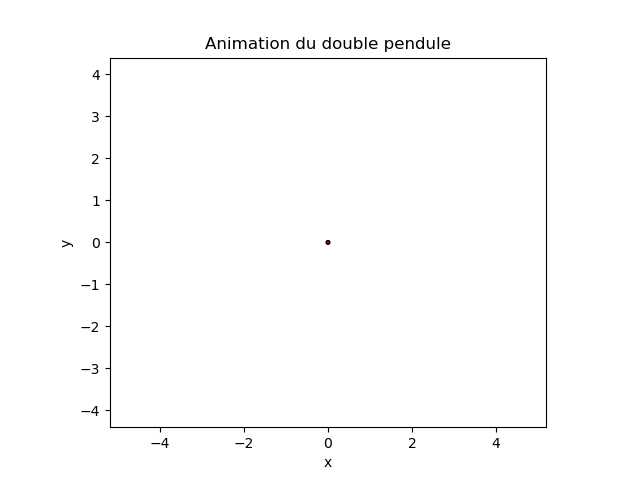

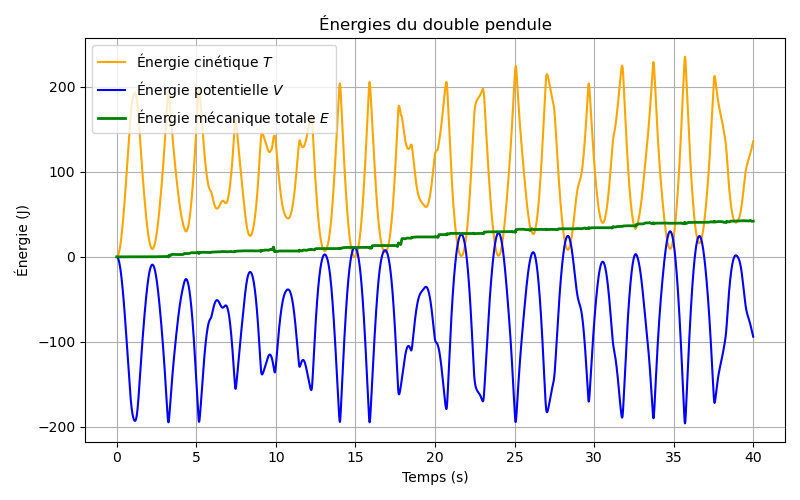

In [22]:
# Animation du pendule

def run_animation():
    anim_running = True

    def onClick(event):
        nonlocal anim_running
        if anim_running:
            anim.event_source.stop()
            anim_running = False
        else:
            anim.event_source.start()
            anim_running = True

    def update(frame):
        thetaf1 = theta1[frame]
        thetaf2 = theta2[frame]
        c1 = [l1 * np.sin(thetaf1), -l1 * np.cos(thetaf1)]
        c2 = [c1[0] + l2 * np.sin(thetaf2), c1[1] - l2 * np.cos(thetaf2)]

        xc2 = l1 * np.sin(theta1) + l2 * np.sin(theta2)
        yc2 = -l1 * np.cos(theta1) - l2 * np.cos(theta2)

        if frame < Nper:
            trace_x2 = xc2[:frame]
            trace_y2 = yc2[:frame]
        else:
            trace_x2 = xc2[frame - Nper:frame]
            trace_y2 = yc2[frame - Nper:frame]

        line1.set_data([0, c1[0]], [0, c1[1]])
        circle1.center = (c1[0], c1[1])

        line2.set_data([c1[0], c2[0]], [c1[1], c2[1]])
        circle2.center = (c2[0], c2[1])
        trace2.set_data(trace_x2, trace_y2)

        time_text.set_text(time_template % (frame * dt))
        return line1, line2, trace1, trace2, circle1, circle2, time_text

    fig.canvas.mpl_connect('button_press_event', onClick)
    anim = FuncAnimation(fig, update, frames=range(0, N),
                         blit=True, interval=dt*10 )
    plt.show()


if anim:
    omega = np.sqrt(g / l1)
    periode = 2 * np.pi / omega
    Nper = round(periode / dt)

    fig, ax = plt.subplots()
    maxdim = 1.3 * (l1 + l2)
    ax.set_xlim(-maxdim, maxdim)
    ax.set_ylim(-1.1 * (l1 + l2), 1.1 * (l1 + l2))
    line1, = ax.plot([], [], 'r-', lw=2)
    circle1 = plt.Circle((0, 0), 0.04, facecolor='r', edgecolor='k')
    trace1, = ax.plot([], [], '-', c='orange', lw=1)
    line2, = ax.plot([], [], 'r-', lw=2)
    circle2 = plt.Circle((0, 0), 0.04, facecolor='r', edgecolor='k')
    trace2, = ax.plot([], [], '-', c='orange', lw=1)

    ax.add_patch(circle1)
    ax.add_patch(circle2)
    ax.set_aspect('equal')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_title('Animation du double pendule')
    time_template = 'time = %.1fs/' + str(round(tf)) + 's'
    time_text = ax.text(0.75, 0.95, '', transform=ax.transAxes)

    run_animation()
    

# Affichage graphique des énergies


plt.figure(figsize=(8,5))
plt.plot(t, T, label="Énergie cinétique $T$", color='orange')
plt.plot(t, V, label="Énergie potentielle $V$", color='blue')
plt.plot(t, E, label="Énergie mécanique totale $E$", color='green', linewidth=2)
plt.xlabel("Temps (s)")
plt.ylabel("Énergie (J)")
plt.title("Énergies du double pendule")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

    


En observant les valeurs de l'énergie mécanique on voit qu'elle augmente un peu.
Ceci est du a l'utilisation de solve_ivp qui peut avoir des incertitudes.

Pour la suite nous allons comparer les trajectoires des masses m2 sur un temps donné 7s

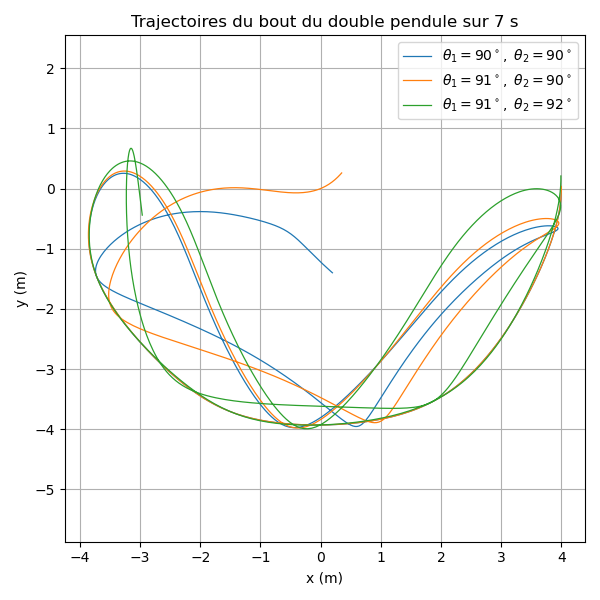

In [63]:
# === Trajectoires du double pendule sur un même plot ===
# Trois conditions initiales, durée 7 s

def trajectory(theta1, theta2):
    x2 = l1 * np.sin(theta1) + l2 * np.sin(theta2)
    y2 = -l1 * np.cos(theta1) - l2 * np.cos(theta2)
    return x2, y2

# Temps d'observation
t_obs = 7
N_obs = int(t_obs / dt)

# --- Cas 1 : 90° / 90°
theta0_1 = np.array([90*np.pi/180, 90*np.pi/180, 0, 0])
sol1 = solve_ivp(
    f,
    (0, t_obs),
    theta0_1,
    t_eval=np.linspace(0, t_obs, N_obs)
)
x2_1, y2_1 = trajectory(sol1.y[0], sol1.y[1])

# --- Cas 2 : 91° / 90°
theta0_2 = np.array([91*np.pi/180, 90*np.pi/180, 0, 0])
sol2 = solve_ivp(
    f,
    (0, t_obs),
    theta0_2,
    t_eval=np.linspace(0, t_obs, N_obs)
)
x2_2, y2_2 = trajectory(sol2.y[0], sol2.y[1])

# --- Cas 3 : 91° / 91°
theta0_3 = np.array([91*np.pi/180, 95*np.pi/180, 0, 0])
sol3 = solve_ivp(
    f,
    (0, t_obs),
    theta0_3,
    t_eval=np.linspace(0, t_obs, N_obs)
)
x2_3, y2_3 = trajectory(sol3.y[0], sol3.y[1])

# --- Affichage sur un même graphique
plt.figure(figsize=(6,6))
plt.plot(x2_1, y2_1, lw=0.9, label=r"$\theta_1=90^\circ,\ \theta_2=90^\circ$")
plt.plot(x2_2, y2_2, lw=0.9, label=r"$\theta_1=91^\circ,\ \theta_2=90^\circ$")
plt.plot(x2_3, y2_3, lw=0.9, label=r"$\theta_1=91^\circ,\ \theta_2=92^\circ$")

plt.xlabel("x (m)")
plt.ylabel("y (m)")
plt.title("Trajectoires du bout du double pendule sur 7 s")
plt.axis("equal")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


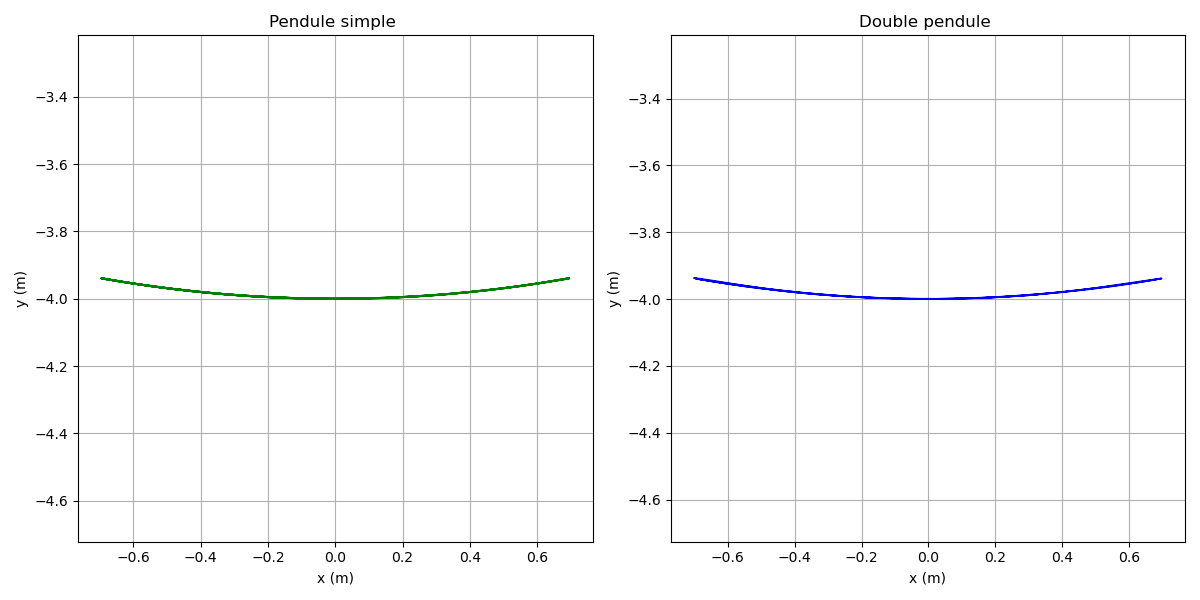

In [62]:
# --- Longueurs
L_simple = l1 + l2  # longueur équivalente au double pendule

# --- Fonction trajectoire
def trajectory_double(theta1, theta2):
    x2 = l1 * np.sin(theta1) + l2 * np.sin(theta2)
    y2 = -l1 * np.cos(theta1) - l2 * np.cos(theta2)
    return x2, y2

def trajectory_simple(theta):
    x = L_simple * np.sin(theta)
    y = -L_simple * np.cos(theta)
    return x, y

# --- Petites oscillations < 15°
theta0_double = np.array([10*np.pi/180, 10*np.pi/180, 0, 0])

# Angle initial du pendule simple = somme des angles du double pendule
theta0_simple = np.array([theta0_double[0], 0, 0, 0])

# --- Résolution temporelle
t_obs = 7
N_obs = int(t_obs / dt)
t_eval = np.linspace(0, t_obs, N_obs)

# Double pendule
sol_double = solve_ivp(f, (0, t_obs), theta0_double, t_eval=t_eval)
x2_double, y2_double = trajectory_double(sol_double.y[0], sol_double.y[1])

# Pendule simple (même longueur totale)
sol_simple = solve_ivp(lambda t, y: [y[2], y[3], -g/L_simple*np.sin(y[0]), 0], 
                       (0, t_obs), theta0_simple, t_eval=t_eval)
x_simple, y_simple = trajectory_simple(sol_simple.y[0])

plt.close()
# --- Affichage côte à côte
fig, axes = plt.subplots(1, 2, figsize=(12,6))


# Trajectoire du pendule simple
axes[0].plot(x_simple, y_simple, lw=1.5, color="green")
axes[0].set_title("Pendule simple ")
axes[0].set_xlabel("x (m)")
axes[0].set_ylabel("y (m)")
axes[0].axis("equal")
axes[0].grid(True)

# Trajectoire du double pendule
axes[1].plot(x2_double, y2_double, lw=1.2, color="blue")
axes[1].set_title("Double pendule ")
axes[1].set_xlabel("x (m)")
axes[1].set_ylabel("y (m)")
axes[1].axis("equal")
axes[1].grid(True)

plt.tight_layout()
plt.show()



**Coefficient de Lyapunov.**

Le coefficient de Lyapunov permet de quantifier la sensibilité aux conditions initiales d’un système dynamique. 

Deux trajectoires du double pendule sont simulées avec une perturbation initiale infinitésimale $\varepsilon \ll 1$.

La divergence entre ces trajectoires est mesurée par

$\delta(t) = \|\mathbf{X}_1(t) - \mathbf{X}_2(t)\|,$

où $\mathbf{X}_1(t) = (\theta_1,\theta_2,\dot{\theta}_1,\dot{\theta}_2)$ est le vecteur d’état du système 1.

Le coefficient de Lyapunov maximal est alors estimé numériquement par

$\lambda \approx \frac{1}{\Delta t}
\left\langle
\ln\!\left(\frac{\delta(t_{i+1})}{\delta(t_i)}\right)
\right\rangle.$

Une valeur $\lambda > 0$ caractérise un comportement chaotique. 

Dans notre étude paramétrique, le coefficient maximal est obtenu pour une configuration asymétrique des longueurs, $l_1 = 15\ \mathrm{cm}$ et $l_2 = 8\ \mathrm{cm}$, correspondant au régime le plus instable observé sur la fenêtre temporelle considérée.


La cellule suivante montre comment nous avons pu obtenir ce résultat ainsi qu'une heatmap pour plusieurs valeurs données.

Configuration correspondante a la valeur maximale du coefficient de Lyapunov 1.247034688839081 : l1 = 0.15 , l2 = 0.075


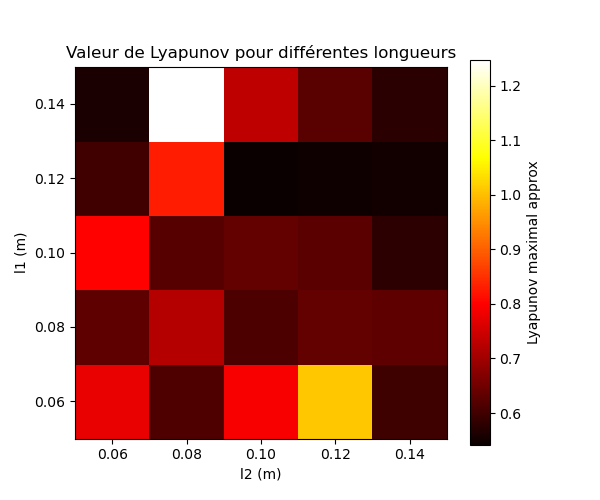

In [49]:
import pandas as pd

# Plage de longueurs à tester (en m)
longueurs = np.linspace(0.05, 0.15, 5)  # 5 valeurs de 5cm à 15cm

# Petite différence initiale pour la divergence
epsilon = 1e-8

# Fonction pour calculer le Lyapunov approximatif
def lyapunov(l1_test, l2_test):
    # Conditions initiales avec légère perturbation
    theta0_pert = np.array([theta0[0], theta0[1]+epsilon, theta0[2], theta0[3]])
    
    # Intégration avec les longueurs testées
    sol = solve_ivp(f, [0, tf], theta0_pert, t_eval=np.linspace(0, tf, len(t)), args=())
    
    # Différence angulaire approximative
    delta_theta = np.abs(sol.y[0] - sol.y[1])
    delta_theta[delta_theta==0] = 1e-12  # éviter log(0)
    
    # Exposant Lyapunov approx
    lamb_max = np.mean(np.log(delta_theta[1:] / delta_theta[:-1])) / (t[1]-t[0])
    return lamb_max

# Calcul pour toutes les combinaisons l1 x l2
resultats = []
for l1_test in longueurs:
    for l2_test in longueurs:
        # Mettre à jour les variables globales pour l1 et l2 
        l1_backup, l2_backup = l1, l2  # sauvegarde
        l1, l2 = l1_test, l2_test
        lam = lyapunov(l1, l2)
        resultats.append({'l1': l1, 'l2': l2, 'Lyapunov': lam})
        l1, l2 = l1_backup, l2_backup  # restaurer
        

# Création d'un DataFrame
df_lyapunov = pd.DataFrame(resultats)
max_lyap = df_lyapunov['Lyapunov'].max()
max_row = df_lyapunov.loc[df_lyapunov['Lyapunov'].idxmax()]
print("Configuration correspondante a la valeur maximale du coefficient de Lyapunov",max_lyap,": l1 =", max_row['l1'], ", l2 =", max_row['l2'])

# Heatmap pour visualiser
plt.close('all')
pivot = df_lyapunov.pivot(index='l1', columns='l2', values='Lyapunov')
plt.figure(figsize=(6,5))
plt.imshow(pivot, origin='lower', cmap='hot', extent=[0.05,0.15,0.05,0.15])
plt.colorbar(label='Lyapunov maximal approx')
plt.xlabel('l2 (m)')
plt.ylabel('l1 (m)')
plt.title('Valeur de Lyapunov pour différentes longueurs')
plt.show()
